In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from math import sqrt
from fastdtw import fastdtw as dtw
from scipy.spatial.distance import euclidean
from scipy import stats

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import os

%matplotlib inline

# Analysis

In [89]:
def get_filenames(rel_path, match):
    return [fn for fn in os.listdir("./" + rel_path) if fn.startswith(match)]
flist_up = get_filenames("data/up", "emg")
flist_down = get_filenames("data/down", "emg")

In [90]:
def sample_reader(filename, label):
    with open(filename, 'r') as csvfile:
        raw = []
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            raw.append([int(p) for p in row[1:]])
            
    treated = [[item[i] for item in raw[:]] for i in range(8)]
    treated.append(label)
    
    return treated

In [223]:
def make_sets(downset, upset):
    X = []
    y = []

    for s in downset:
        X.append(s[:-1])
        y.append(s[-1])

    for s in upset:
        X.append(s[:-1])
        y.append(s[-1])
    
    return X, y
    

In [91]:
def plot_sample(s, additional_label=''):
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(s[8] + ' Strum ' + additional_label, fontsize=20)
    ax1 = fig.add_subplot(111)
    for i in range(9):
        ax1.legend(loc='upper left')
        ax1.plot(s[i], label=str(i))

In [98]:
def get_distances(t1, t2):
    dists = []
    paths = []
    for i in range(8):
        d, p = dtw(t1[i], t2[i], dist=euclidean)
        dists.append(d)
        paths.append(p)
    
    return dists, paths

def distance_measure(t1, t2):
    dists, paths = get_distances(t1, t2)
    return sqrt([n * n for n in dists] / len(dists))

In [197]:
def moving_average(mylist, N):
    cumsum, ma = [0], []

    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            ma.append(moving_ave)
    return ma

In [227]:
def get_accuracy(model, X_test, y_test):
    preds = [model.predict(x) for x in X_test]
    correct = 0
    for i in range(len(y_test)):
        if preds[i] == y_test[i]:
            correct += 1
    accuracy = correct / len(y_test)
    return accuracy, preds

In [233]:
def smooth_sample(sample, windows):
    nsamp = [moving_average(ts, windows) for ts in sample[:-1]]
    nsamp.append(sample[-1])
    return nsamp

def smooth_dataset(dset, windows):
    return [smooth_sample(samp, windows) for samp in dset]

In [215]:
# Pull all data
downset = [sample_reader('data/down/' + fname, 'down') for fname in flist_down]
upset = [sample_reader('data/up/' + fname, 'up') for fname in flist_up]

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

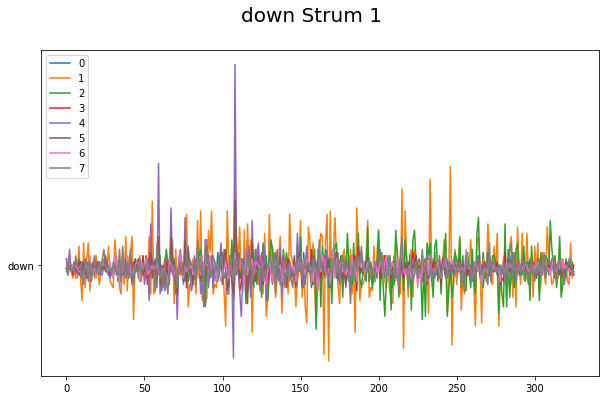

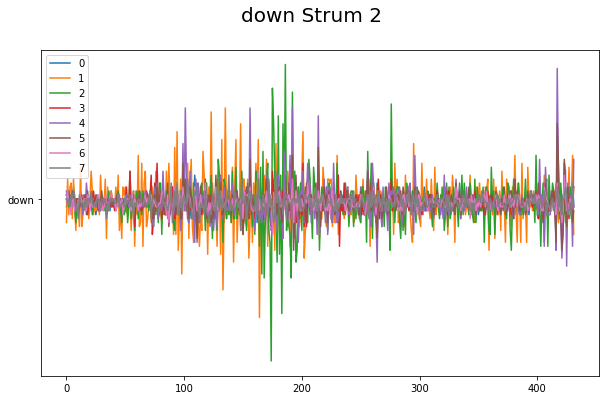

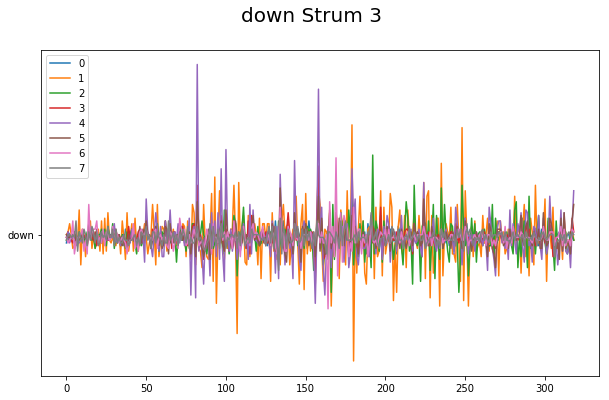

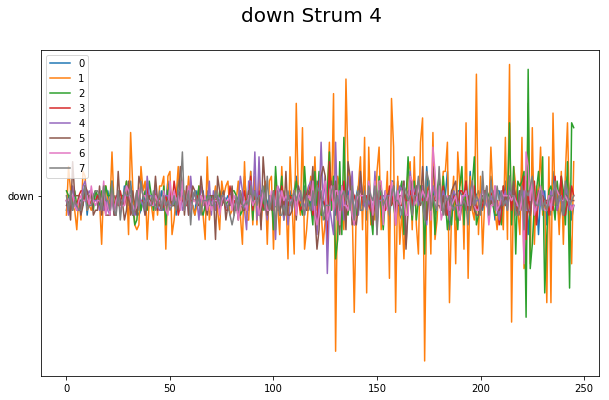

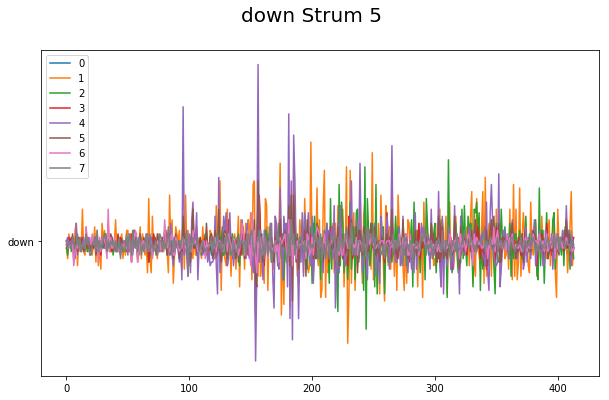

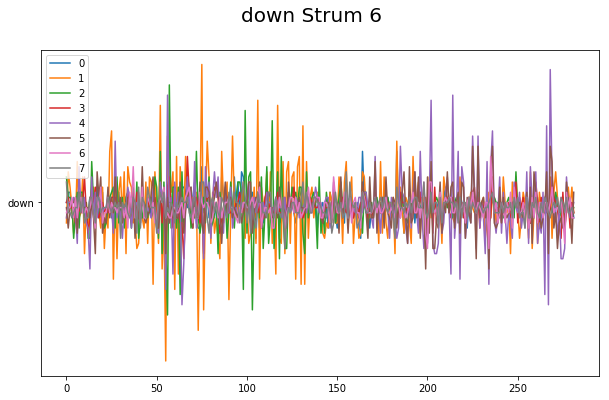

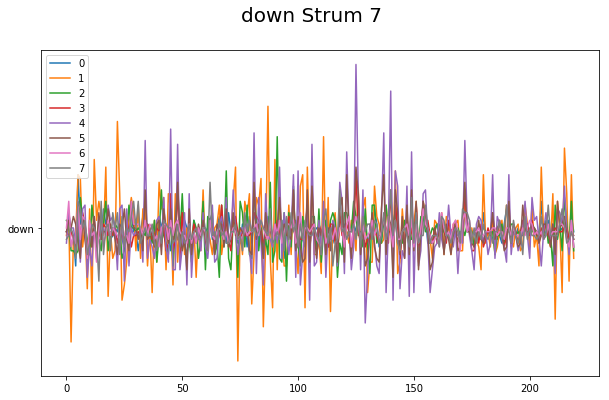

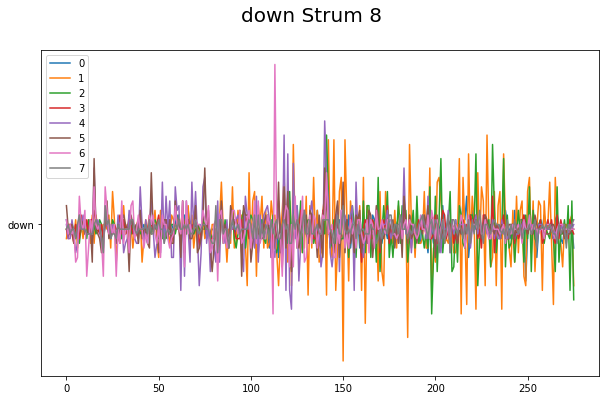

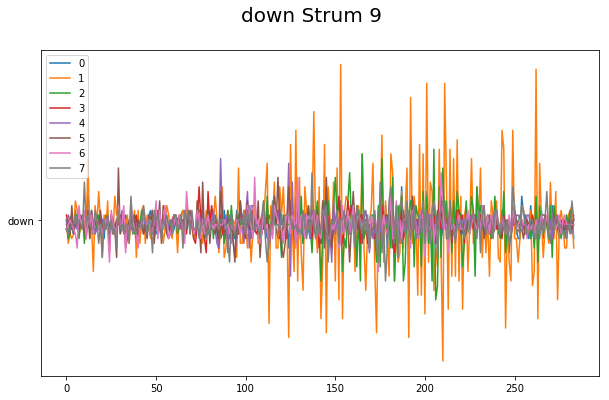

In [94]:
for i in range(len(downset)):
    plot_sample(downset[i], str(i + 1))

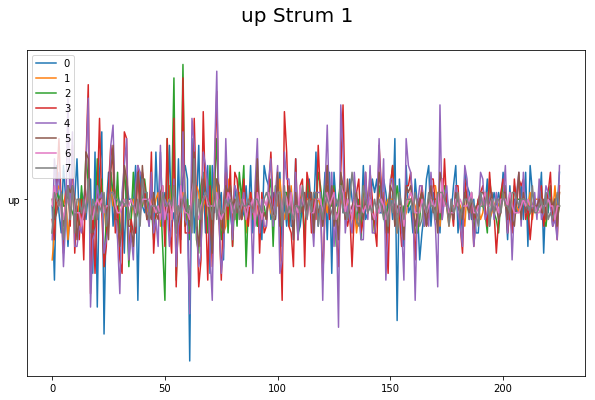

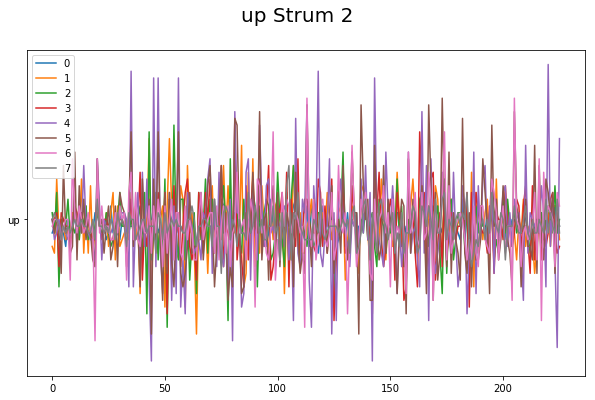

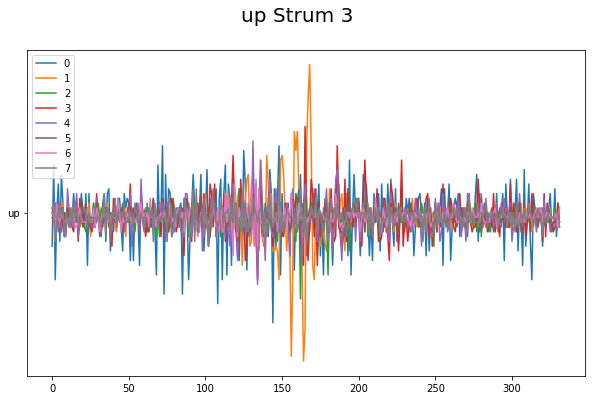

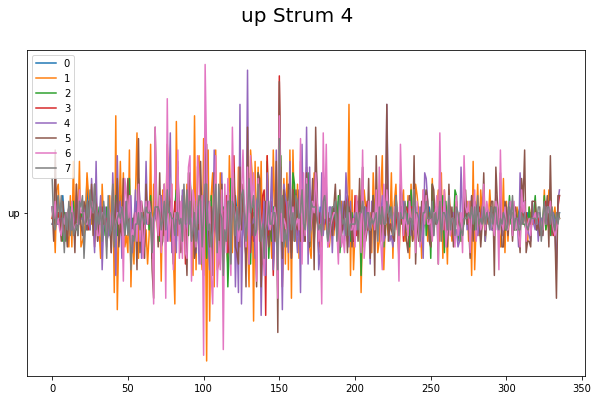

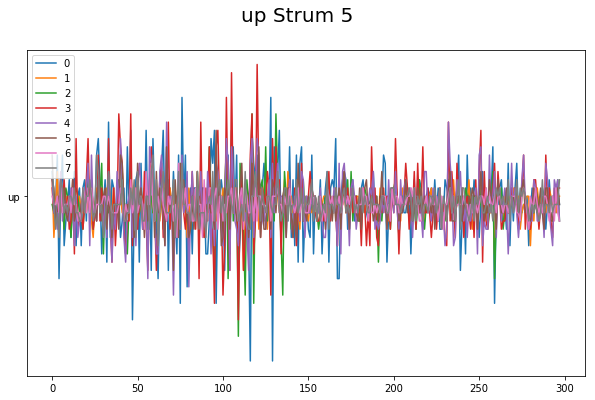

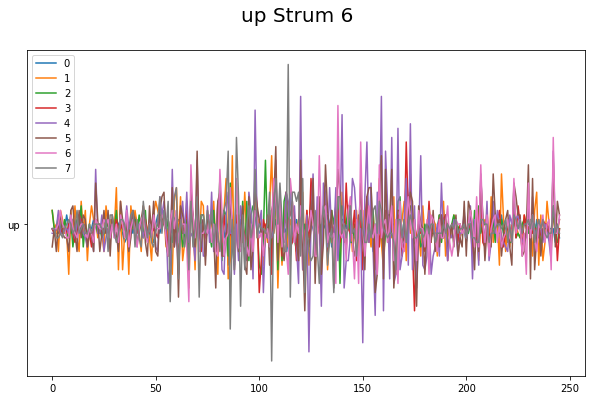

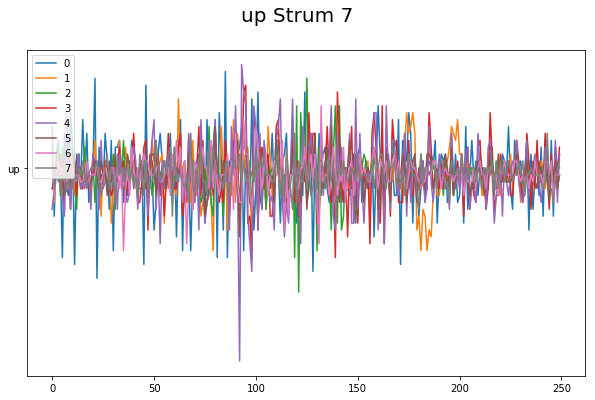

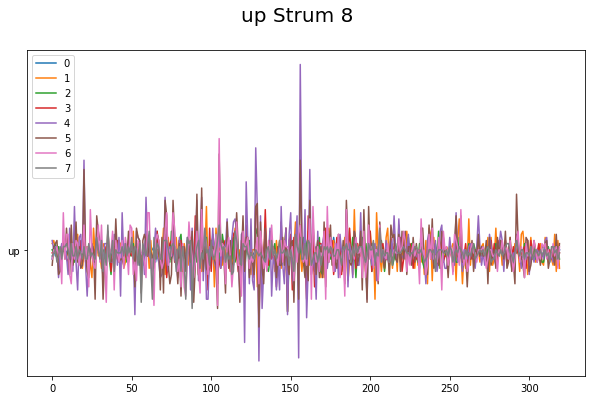

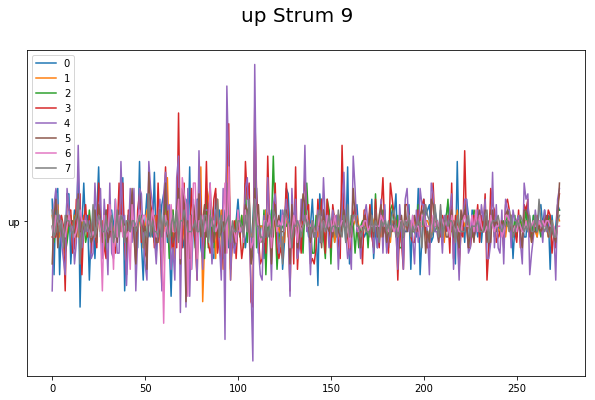

In [95]:
# Isolate one up sample and turn it to test data
for i in range(len(upset) - 1):
    plot_sample(upset[i], str(i + 1))
test = upset[-1]

In [225]:
class kNNTimeSeries:
    def __init__(self, n_neighbors, f):
        self.preds = []
        self.X_train = None
        self.y_train = None
        self.metric = f
        self.neighbors = n_neighbors
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, x_test):
        for ind, sample in enumerate(self.X_train):
            dist = self.metric(sample, x_test)
            self.preds.append([dist, ind, y_train[ind]])
        self.preds = sorted(self.preds, key=lambda x: x[0])
        
        # Poll based on number of neighbors
        if self.neighbors == 1:
            return self.preds[0]
        elif self.neighbors % 2 != 0:
            voters = self.preds[:self.neighbors]
            c1 = [v for v in voters if v[2] == 'up']
            c2 = [v for v in voters if v[2] == 'down']
            if len(c1) > len(c2):
                return 'up'
            else:
                return 'down'

In [174]:
knn = kNNTimeSeries(7, distance_metric)
knn.fit(X_train, y_train)
ps = knn.predict(X_test[0])

In [180]:
acc, predictions = get_accuracy(knn, X_test, y_test)

In [181]:
kappa = cohen_kappa_score(predictions, y_test)
print(kappa, acc)

0.0 0.4


In [178]:
kappa = cohen_kappa_score(predictions, y_test)
print(kappa, acc)

0.285714285714 0.6


# With Moving Average

In [237]:
smooth_down = smooth_dataset(downset, 200)
smooth_up = smooth_dataset(upset, 200)
sX, sy = make_sets(smooth_down, smooth_up)

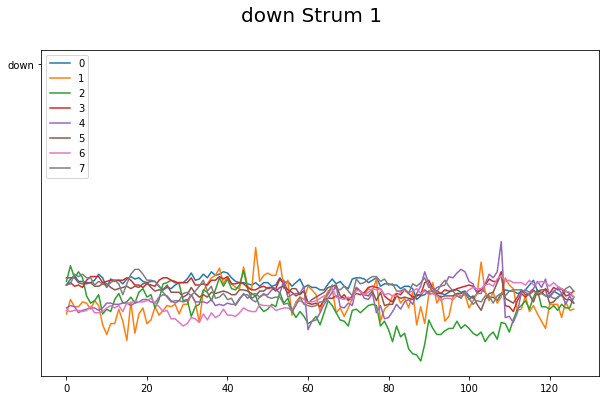

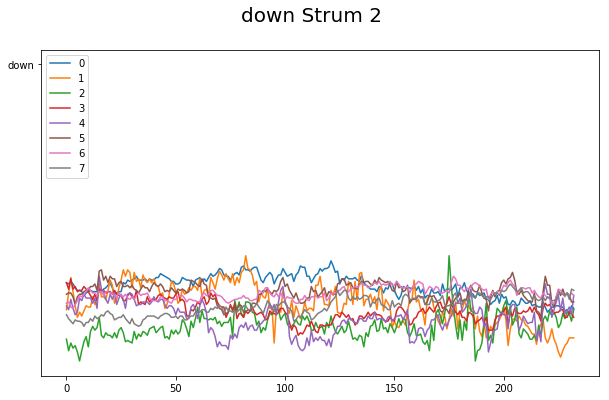

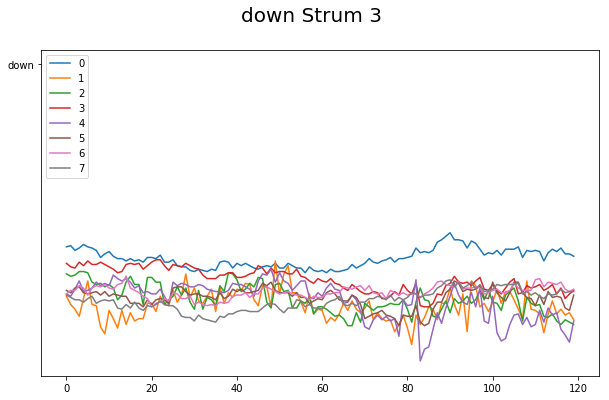

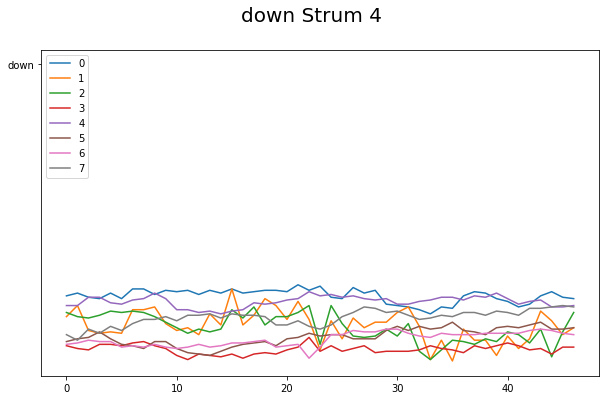

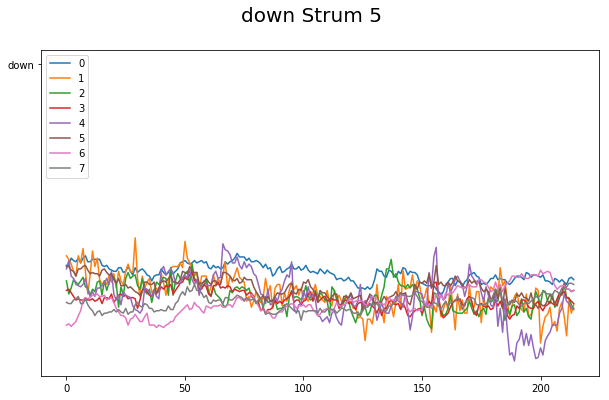

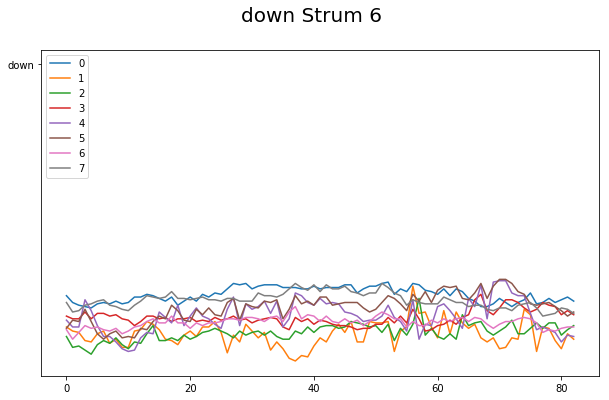

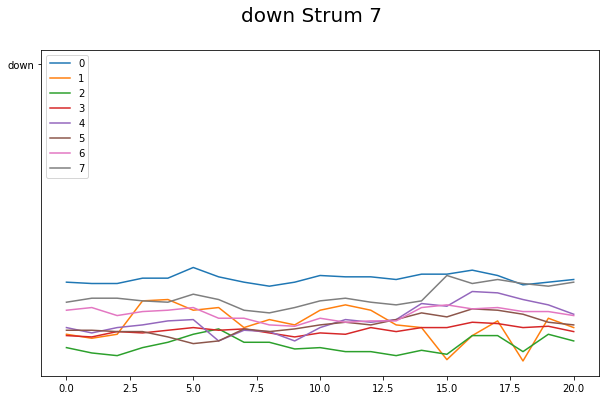

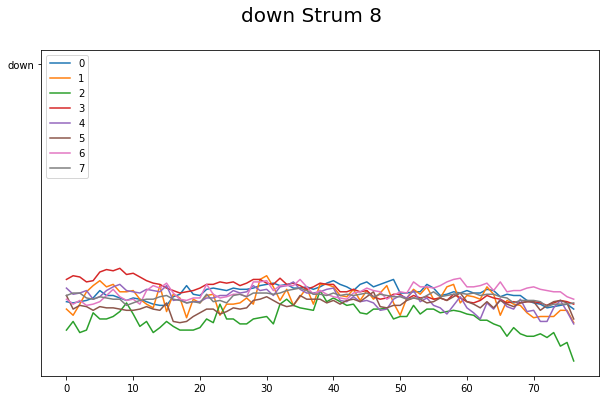

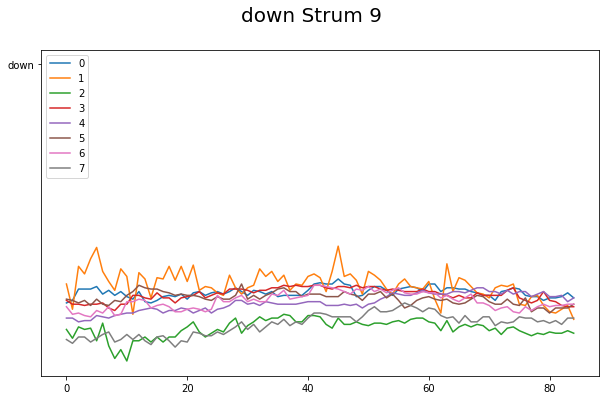

In [238]:
for i in range(len(smooth_down)):
    plot_sample(smooth_down[i], str(i + 1))

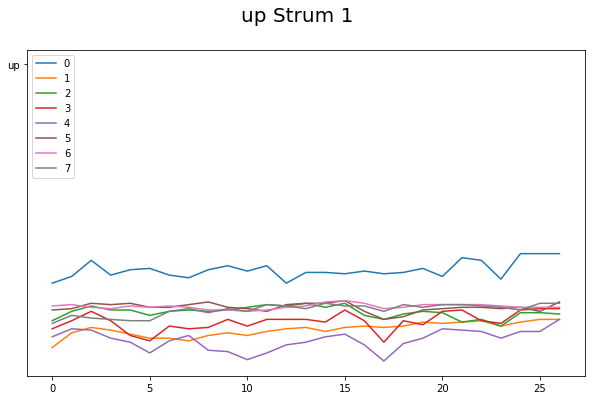

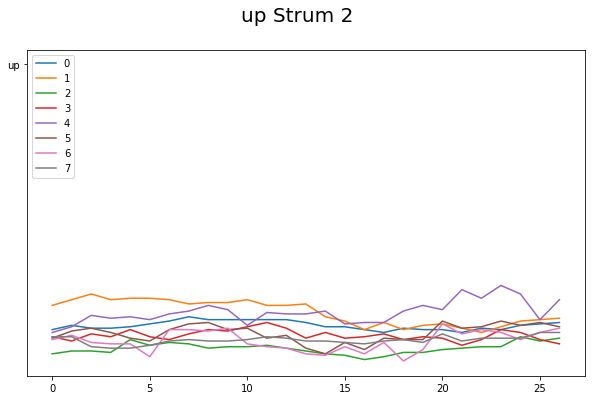

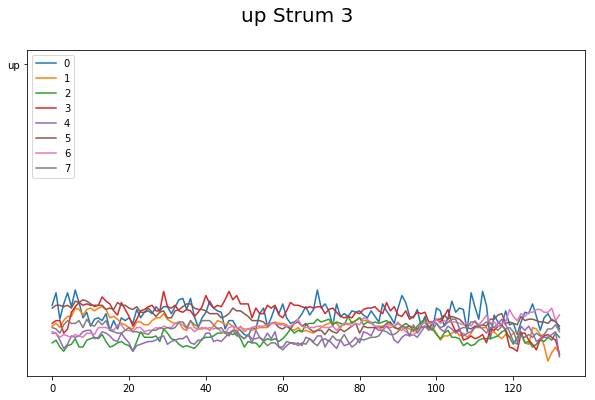

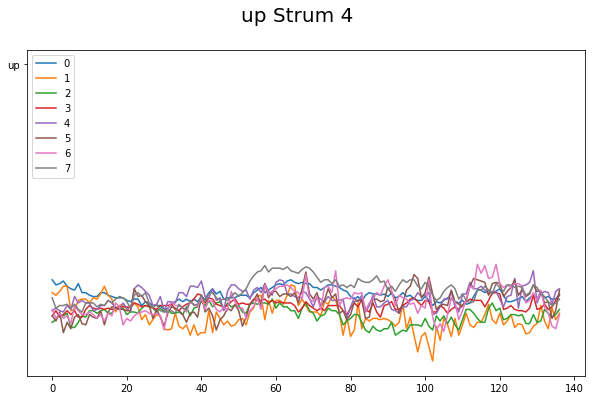

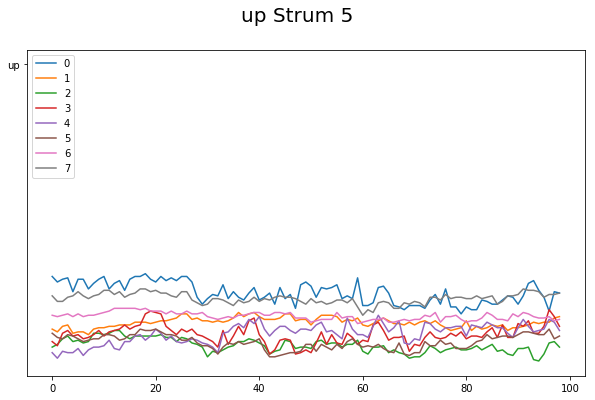

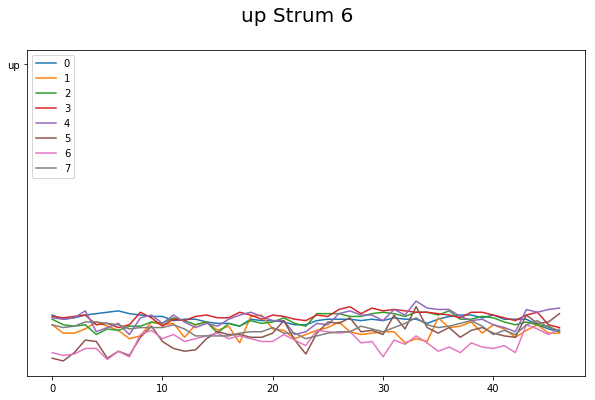

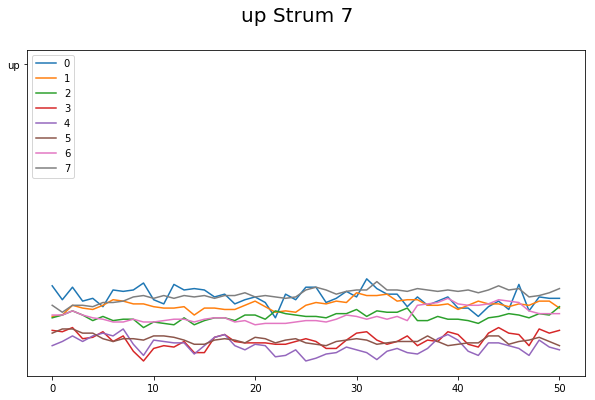

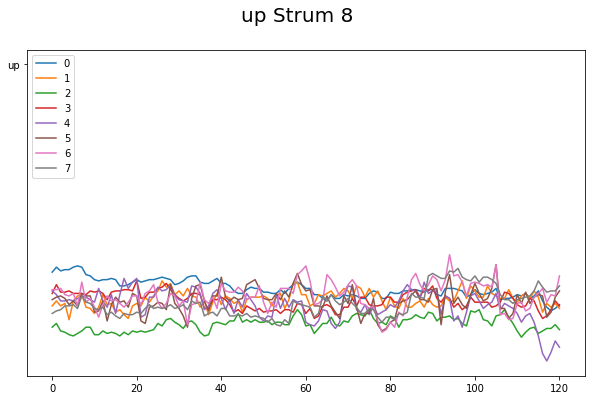

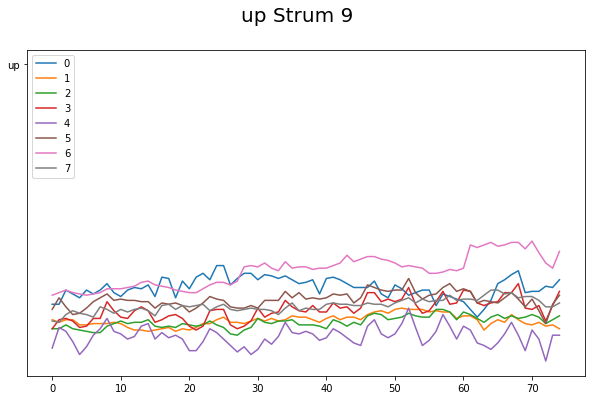

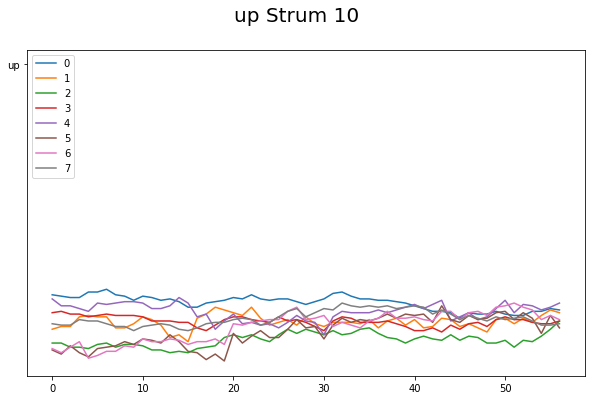

In [239]:
for i in range(len(smooth_up)):
    plot_sample(smooth_up[i], str(i + 1))

In [240]:
X_train_smooth, X_test_smooth, y_train_smooth, y_test_smooth = train_test_split(sX, sy)

In [241]:
knns = kNNTimeSeries(7, distance_metric)
knns.fit(X_train_smooth, y_train_smooth)

In [242]:
acc, predictions = get_accuracy(knn, X_test_smooth, y_test_smooth)

In [243]:
kappa = cohen_kappa_score(predictions, y_test)
print(kappa, acc)

0.0 0.4
